## Short-term SMA crossover research fun

Some simplified research - profitability of short-term SMA crossover strategy.

The aim of this notebook was to practice:
- data retrieval using Binance API
- working with time-series data
- plot creation


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def public_request(url, payload={}):
    endpoint = 'https://api.binance.com'
    req = requests.get(endpoint+url, params=payload)
    return req

symbol = 'BTCUSDT'
interval = '30m'
limit = 1000

kline_url = '/api/v3/klines'
kline_payload = {'symbol': symbol, 'interval': interval, 'limit': limit}

r = public_request(kline_url, payload=kline_payload).json()

In [2]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'n_o_t', 't_b_vol', 't_b_quote_vol', 'ign']

df = pd.DataFrame(r, columns=columns)

df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

df = df.drop(columns=df.loc[:, 'volume':'ign'].columns)
df.set_index('open_time', inplace=True)
df = df.astype(float)
df

,open,high,low,close
open_time,,,,
2020-11-16 01:30:00,15976.51,16004.96,15939.03,15948.00
2020-11-16 02:00:00,15947.99,16008.82,15947.99,15952.37
2020-11-16 02:30:00,15952.37,15969.00,15922.57,15935.15
2020-11-16 03:00:00,15935.15,15982.40,15932.14,15977.82
2020-11-16 03:30:00,15977.82,16048.55,15977.81,16006.50
...,...,...,...,...
2020-12-06 20:00:00,19132.62,19152.77,19123.41,19140.03
2020-12-06 20:30:00,19140.03,19184.62,19130.00,19168.73
2020-12-06 21:00:00,19168.73,19173.00,19114.01,19148.88


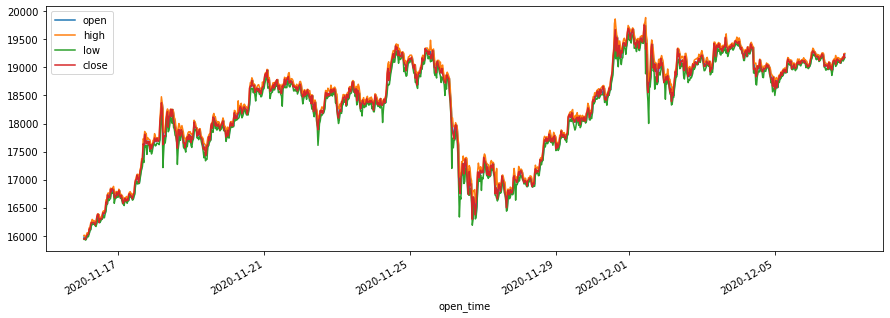

In [3]:
df.plot(figsize=(15,5));

In [4]:
df['hlc'] = (df['high'] + df['low'] + df['close']) / 3
df['sma3'] = df['close'].rolling(3).mean()
# df['sma3'].plot(figsize=(12,8))

df.loc[df['hlc'] > df['sma3'] * 1.005, 'signal_long'] = 1
df.loc[df['hlc'] < df['sma3'] * 0.995, 'signal_short'] = 1

df

,open,high,low,close,hlc,sma3,signal_long,signal_short
open_time,,,,,,,,
2020-11-16 01:30:00,15976.51,16004.96,15939.03,15948.00,15963.996667,NaN,NaN,NaN
2020-11-16 02:00:00,15947.99,16008.82,15947.99,15952.37,15969.726667,NaN,NaN,NaN
2020-11-16 02:30:00,15952.37,15969.00,15922.57,15935.15,15942.240000,15945.173333,NaN,NaN
2020-11-16 03:00:00,15935.15,15982.40,15932.14,15977.82,15964.120000,15955.113333,NaN,NaN
2020-11-16 03:30:00,15977.82,16048.55,15977.81,16006.50,16010.953333,15973.156667,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-06 20:00:00,19132.62,19152.77,19123.41,19140.03,19138.736667,19117.286667,NaN,NaN
2020-12-06 20:30:00,19140.03,19184.62,19130.00,19168.73,19161.116667,19147.126667,NaN,NaN
2020-12-06 21:00:00,19168.73,19173.00,19114.01,19148.88,19145.296667,19152.546667,NaN,NaN


In [5]:
def backtest(df, long_only=False):
    pcts = []
    long_price = []
    short_price = []
    prev_price = None
    position = None

    for index, row in df.iterrows():
        if position == 'long' and row['signal_short'] == 1:
            pcts.append(row['hlc'] / prev_price - 1)
            position = None
            short_price.append((index, row['hlc']))
        elif position == 'short' and row['signal_long'] == 1:
            pcts.append(prev_price / row['hlc'] - 1)
            position = None
            long_price.append((index, row['hlc']))

        if position == None and row['signal_long'] == 1:
            prev_price = row['hlc']
            position = 'long'
            long_price.append((index, row['hlc']))
        elif not long_only and position == None and row['signal_short'] == 1:
            prev_price = row['hlc']
            position = 'short'
            short_price.append((index, row['hlc']))

    return pcts, long_price, short_price

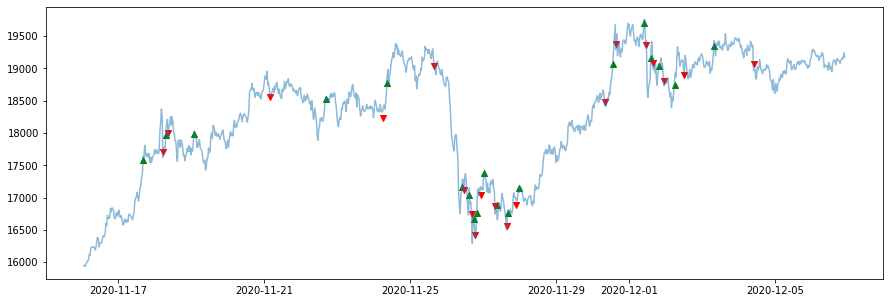

In [6]:
test, longs, shorts = backtest(df, long_only=True)

long_index = [i[0] for i in longs]
long_price = [i[1] for i in longs]

short_index = [i[0] for i in shorts]
short_price = [i[1] for i in shorts]

plt.figure(figsize=(15,5))
plt.plot(df.index, df.close, alpha=0.5)
plt.scatter(long_index, long_price, c='green', marker='^')
plt.scatter(short_index, short_price, c='red', marker='v')
plt.show()

In [7]:
fee = 0.001 # Binance tier 0 fee (0.1%) for maker/taker

# no stoploss
cap = 1
for i in test:
    cap *= (1 + i - 2 * fee)

winrate = len([i for i in test if i > 0]) / len(test)

print(len(test), 'trades in', df.index[-1] - df.index[0])
print(f'Winrate: {round(winrate*100,2)}%')
print()
print('Endcap without stoploss:', round(cap,8))
print(f'Profit: {round((cap-1)*100,2)}%')
print()

# stoploss at 2%
stoploss = -0.02
test2 = [i if i > stoploss else stoploss for i in test]
cap = 1
for i in test2:
    cap *= (1 + i - 2 * fee)

print('Endcap with stoploss:', round(cap,8))
print(f'Profit: {round((cap-1)*100,2)}%')

19 trades in 20 days 20:30:00
Winrate: 47.37%

Endcap without stoploss: 0.99041003
Profit: -0.96%

Endcap with stoploss: 0.99996052
Profit: -0.0%
